In [67]:
import sys
sys.path.append('../../')

from IPython.core.display import display
import numpy as np
import pandas as pd
import networkx as nx
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter

In [7]:
# import node embeddings
df = pd.read_csv(
    "./karate_club_alpha-0.1_beta-0.1_ws-10_neg-5_lr-0.025_icom-362_ind-362_k-5_ds-0.0.txt",
    sep="\t| ",
    header=None
)
df = df.rename(columns={0: 'node'})
df.set_index(['node'], inplace=True)
df

/Users/anton/miniconda3/envs/MT/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,1,2
node,,
0,-0.005211,-1.090077
1,0.234183,-0.874326
2,0.490883,-0.682946
3,0.169664,-0.959395
4,-0.221307,-1.477360
5,-0.356060,-1.700488
6,-0.310993,-1.730003
7,0.166877,-0.969558
8,0.706476,-0.545441


In [6]:
# import predicted labels
labels = pd.read_csv("./labels_pred.txt", header=None)
labels = labels.rename(columns={0: 'label'})
labels.label = labels.astype(int)
labels

,label
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,1
9,1


In [8]:
df = df.join(labels)

In [10]:
# node embeddings
display(df)
display(df.describe())

,1,2,label
node,,,
0,-0.005211,-1.090077,0
1,0.234183,-0.874326,0
2,0.490883,-0.682946,0
3,0.169664,-0.959395,0
4,-0.221307,-1.477360,0
5,-0.356060,-1.700488,0
6,-0.310993,-1.730003,0
7,0.166877,-0.969558,0
8,0.706476,-0.545441,1


,1,2,label
count,34.000000,34.000000,34.000000
mean,0.676561,-0.773000,0.529412
std,0.672893,0.467923,0.506640
min,-0.412848,-2.036346,0.000000
25%,0.133605,-1.021683,0.000000
50%,0.683970,-0.568003,1.000000
75%,1.321986,-0.391642,1.000000
max,1.661324,-0.348751,1.000000


In [15]:
def emb_from_row(row):
    """get node embedding np array from df row"""
    return row.drop('label').to_numpy().flatten()

def emb_distance(emb1, emb2):
    """computes the euclidean distance between two node embeddings"""
    return np.linalg.norm(emb1-emb2)

In [13]:
# get nx train graph
G = nx.karate_club_graph()

# DEBUG remove some edges for karate_club
print("PRE NUM_OF_EDGES: ", G.number_of_edges())
G.remove_edge(33, 23)
G.remove_edge(0, 1)
G.remove_edge(32, 30)
print("POST NUM_OF_EDGES: ", G.number_of_edges())

PRE NUM_OF_EDGES:  78
POST NUM_OF_EDGES:  75


In [40]:
test_users = [33, 0, 32]
test_friends = {
    33: 23,
    0: 1,
    32: 30
}

# compute Top-N lists for test dataset
# for each testing row
results = {}
for i, userId in enumerate(test_users):
    if not userId in df.index: continue
    user_label = df.loc[userId].label
    print("user_label: ", user_label)
    user_emb = emb_from_row(df.loc[userId])
    print("user_emb: ", user_emb)

    # get user's non_friends in user's community
    # users_in_community
    users_in_community = df[df.label == user_label]
    print("len(users_in_community): ", len(users_in_community))
    # friends
    friends = list(G[userId])
    print("len(friends): ", len(friends))
    # not_friends_in_community
    not_friends_in_community = users_in_community[~users_in_community.index.isin(friends+[userId])]
    print("len(not_friends_in_community): ", len(not_friends_in_community))

    # generate user's top_list from all not_friends
    distances = {}
    top_list = SortedDict()
    for movie_id, node_row in not_friends_in_community.iterrows():
        node_emb = emb_from_row(node_row)
        dist = emb_distance(user_emb, node_emb)
        top_list[dist] = movie_id
        distances[movie_id] = dist

    results[userId] = top_list, distances
    print(f"{i}/{len(test_users)}")

user_label:  1.0
user_emb:  [ 1.1190075  -0.40690675]
len(users_in_community):  18
len(friends):  16
len(not_friends_in_community):  3
0/3
user_label:  0.0
user_emb:  [-0.00521125 -1.0900768 ]
len(users_in_community):  16
len(friends):  15
len(not_friends_in_community):  2
1/3
user_label:  1.0
user_emb:  [ 1.2997648  -0.39256394]
len(users_in_community):  18
len(friends):  11
len(not_friends_in_community):  7
2/3


In [41]:
N = 100

# counters
hits = 0
misses = 0

for userId in results.keys():
    (top_list, distances) = results[userId]

    # get Top-N friend suggestions
    top_N = top_list.values()[:N]

    # get user's test friend
    test_friend = test_friends[userId]

    # evaluate
    hit = test_friend in top_N
    if hit:
        hits += 1
    else:
        misses += 1

    print(f"Friend suggestion {test_friend} {'found' if hit else 'not found'} in user {userId}'s Top-{N} list: ", top_N)


Friend suggestion 23 found in user 33's Top-100 list:  [24, 25, 23]
Friend suggestion 1 found in user 0's Top-100 list:  [1, 16]
Friend suggestion 30 found in user 32's Top-100 list:  [25, 24, 27, 26, 28, 9, 30]


In [ ]:
print("hits: ", hits)
print("misses: ", misses)

In [54]:
list(results[32][0].values())

[25, 24, 27, 26, 28, 9, 30]

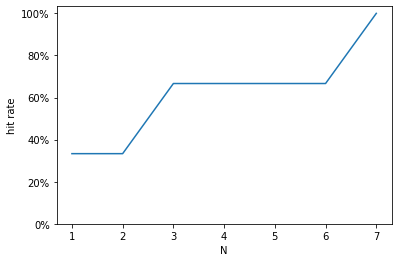

In [75]:
ax = sns.lineplot(x=[1,2,3,4,5,6,7], y=[1/3, 1/3, 2/3, 2/3, 2/3, 2/3, 3/3])
ax.set(xlabel='N', ylabel='hit rate', ylim=(0, None))
ax.yaxis.set_major_formatter(PercentFormatter(1))

fig = ax.get_figure()
fig.savefig("./hit_rates.png")
